
# Traffic and Airprox Correlations
> Author: A.Pilko@soton.ac.uk

2019 Air traffic data and 2000-2021 airprox data is used to investigate correlations in the datasets.

## Hypotheses:
- Airprox locations will have less ordered traffic flow, concretely the variance of traffic direction will positively correlate with airprox locations
- Airprox locations will positively correlate with traffic density
- Airprox locations will positively correlate with mean traffic flow speed
- Airprox locations will positively correlate with the variance of the flow speed


Import required libraries and pre-cleaned data

In [69]:
import geopandas as gpd
import pandas as pd
import seaborn as sns
import traffic
import numpy as np
import pyproj
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import joblib as jl

from cartopy.crs import Projection
from traffic.drawing import countries, lakes, ocean
from traffic.data import airports

%matplotlib inline

In [2]:
airprox_gdf = gpd.GeoDataFrame(pd.read_pickle('../data/airprox_asp_2000_2021.pkl'))
# tfc_clean = traffic.core.Traffic.from_file('../data/cornwall/cornwall_tfc_clean_30s_lt3000ft_2019_f16.pkl.bz2')
tfc_clean = traffic.core.Traffic.from_file('../data/southeng/southeng_tfc_clean_lt5000ft_2019.pkl.bz2')

In [3]:
tfc_df = tfc_clean.data
tfc_df = tfc_df.dropna(axis=0)
tfc_df = tfc_df[(tfc_df['altitude'] > 0) & (tfc_df['altitude'] <= 1524)]
tfc_clean = traffic.core.Traffic(tfc_df)

In [4]:
# tfc_clean_data = pd.read_pickle('../data/cornwall/cornwall_tfc_clean_30s_lt3000ft_2019_f16.pkl.bz2')

In [ ]:
tfc_clean.data.describe()

## Airspace

There isn't much point analysing the traffic patterns for controlled airspace where ATC are issuing instructions or aircraft are (usually) following standard routes (SIDs, STARs). The UK airspace is used to filter out the traffic state vectors that are located in controlled airspace. All the traffic that is only in uncontrolled airspace is then used for the actual analysis.

In [6]:
import requests

req = requests.get('https://storage.googleapis.com/29f98e10-a489-4c82-ae5e-489dbcd4912f/gb_asp.geojson')
with open('gb_asp.geojson', 'w') as f:
    f.write(req.text)

In [7]:
ASP_TYPES = {
    0: "Other",
    1: "Restricted",
    2: "Danger",
    3: "Prohibited",
    4: "Controlled Tower Region (CTR)",
    5: "Transponder Mandatory Zone (TMZ)",
    6: "Radio Mandatory Zone (RMZ)",
    7: "Terminal Maneuvering Area (TMA)",
    8: "Temporary Reserved Area (TRA)",
    9: "Temporary Segregated Area (TSA)",
    10: "Flight Information Region (FIR)",
    11: "Upper Flight Information Region (UIR)",
    12: "Air Defense Identification Zone (ADIZ)",
    13: "Airport Traffic Zone (ATZ)",
    14: "Military Airport Traffic Zone (MATZ)",
    15: "Airway",
    16: "Military Training Route (MTR)",
    17: "Alert Area",
    18: "Warning Area",
    19: "Protected Area",
    20: "Helicopter Traffic Zone (HTZ)",
    21: "Gliding Sector",
    22: "Transponder Setting (TRP)",
    23: "Traffic Information Zone (TIZ)",
    24: "Traffic Information Area (TIA)",
    25: "Military Training Area (MTA)",
    26: "Controlled Area (CTA)",
    27: "ACC Sector (ACC)",
    28: "Aerial Sporting Or Recreational Activity",
    29: "Low Altitude Overflight Restriction"
}

ASP_CLASS = {
    0: "A",
    1: "B",
    2: "C",
    3: "D",
    4: "E",
    5: "F",
    6: "G",
    7: "Special Use Airspace (SUA)",
    8: "Unclassified"
}

ASP_ACTIVITIES = {
    0: "None - No specific activity (default)",
    1: "Parachuting Activity",
    2: "Aerobatics Activity",
    3: "Aeroclub And Arial Work Area",
    4: "Ultra Light Machine (ULM) Activity",
    5: "Hang Gliding/Paragliding"
}

ASP_ALT_UNIT = {
    0: "Meter",
    1: "Feet",
    6: "Flight Level",
}

ASP_ALT_DATUM = {
    0: "GND",
    1: "MSL",
    2: "STD",
}

In [ ]:
asp_gdf = gpd.read_file('gb_asp.geojson')
asp_gdf = asp_gdf[(asp_gdf['approved'] == True) & (asp_gdf['onDemand'] == False) & (asp_gdf['onRequest'] == False) & (
        asp_gdf['byNotam'] == False) & (asp_gdf['specialAgreement'] == False) & (asp_gdf['icaoClass'] < 4)]
asp_gdf = asp_gdf.cx[
          tfc_clean.data.longitude.min():tfc_clean.data.longitude.max(),
          tfc_clean.data.latitude.min(): tfc_clean.data.latitude.max()
          ].reset_index()
asp_upper_lims = pd.DataFrame(pd.json_normalize(asp_gdf.upperLimit))
asp_lower_lims = pd.DataFrame(pd.json_normalize(asp_gdf.lowerLimit))
asp_upper_lims.columns = ['upperLimit_value', 'upperLimit_unit', 'upperLimit_ref']
asp_lower_lims.columns = ['lowerLimit_value', 'lowerLimit_unit', 'lowerLimit_ref']
asp_lim_df = pd.concat([asp_lower_lims, asp_upper_lims], axis=1)
asp_gdf = pd.concat([asp_gdf, asp_lim_df], axis=1)
asp_gdf = asp_gdf.drop(
    labels=['_id', 'approved', 'specialAgreement', 'onDemand', 'onRequest', 'byNotam', 'createdAt', 'createdBy',
            'updatedAt', 'updatedBy', 'upperLimit', 'lowerLimit'], axis=1)
for col in ['type', 'icaoClass', 'activity']:
    asp_gdf[col] = pd.Categorical(asp_gdf[col])
asp_gdf['type'] = asp_gdf['type'].cat.rename_categories(ASP_TYPES)
asp_gdf['icaoClass'] = asp_gdf['icaoClass'].cat.rename_categories(ASP_CLASS)
asp_gdf['activity'] = asp_gdf['activity'].cat.rename_categories(ASP_ACTIVITIES)
asp_gdf

In [9]:
def alt_std(row):
    cr = row.copy()
    if cr['upperLimit_unit'] == 1:
        cr['upperLimit_value'] /= 3.28084
    elif cr['upperLimit_unit'] == 6:
        cr['upperLimit_value'] *= 100/3.28084

    if cr['lowerLimit_unit'] == 1:
        cr['lowerLimit_value'] /= 3.28084
    elif cr['lowerLimit_unit'] == 6:
        cr['lowerLimit_value'] *= 100/3.28084

    return cr


asp_gdf = asp_gdf.apply(alt_std, axis=1).dropna()
asp_gdf = asp_gdf[asp_gdf['lowerLimit_value'] <= tfc_clean.data['altitude'].max()]
asp_gdf = asp_gdf.drop(labels=['upperLimit_unit', 'upperLimit_ref', 'lowerLimit_unit', 'lowerLimit_ref', 'index'], axis=1)

asp_gdf

,name,type,icaoClass,activity,country,hoursOfOperation,geometry,lowerLimit_value,upperLimit_value
1,BRISTOL CTA 125.650,Other,D,None - No specific activity (default),GB,"{'operatingHours': [{'dayOfWeek': 0, 'startTim...","POLYGON ((-2.52833 51.47333, -2.52833 51.47333...",457.199985,3200.399898
2,BRISTOL CTA 125.650,Other,D,None - No specific activity (default),GB,"{'operatingHours': [{'dayOfWeek': 0, 'startTim...","POLYGON ((-2.95883 51.37879, -2.95878 51.38819...",457.199985,3200.399898
3,BRISTOL CTA 125.650,Other,D,None - No specific activity (default),GB,"{'operatingHours': [{'dayOfWeek': 0, 'startTim...","POLYGON ((-2.43722 51.47667, -2.43722 51.47667...",609.599980,3200.399898
4,BRISTOL CTA 125.650,Other,D,None - No specific activity (default),GB,"{'operatingHours': [{'dayOfWeek': 0, 'startTim...","POLYGON ((-2.51250 51.30722, -2.51250 51.30722...",914.399971,3200.399898
5,BRISTOL CTA 125.650,Other,D,None - No specific activity (default),GB,"{'operatingHours': [{'dayOfWeek': 0, 'startTim...","POLYGON ((-2.35111 51.47972, -2.35111 51.47972...",1066.799966,3200.399898
...,...,...,...,...,...,...,...,...,...
109,LONDON STANSTED CTR,Other,D,None - No specific activity (default),GB,"{'operatingHours': [{'dayOfWeek': 0, 'startTim...","POLYGON ((0.44806 51.90444, 0.21917 51.75222, ...",0.000000,1066.799966
110,SOUTHAMPTON CTR 120.230,Other,D,None - No specific activity (default),GB,"{'operatingHours': [{'dayOfWeek': 0, 'startTim...","POLYGON ((-1.33806 51.08306, -1.33806 51.08306...",0.000000,609.599980
111,SOUTHEND CTR 130.780,Other,D,None - No specific activity (default),GB,"{'operatingHours': [{'dayOfWeek': 0, 'startTim...","POLYGON ((0.48417 51.57917, 0.75583 51.70167, ...",0.000000,1066.799966
112,SOUTHEND CTR 130.780,Other,D,None - No specific activity (default),GB,"{'operatingHours': [{'dayOfWeek': 0, 'startTim...","POLYGON ((0.75583 51.70167, 0.79667 51.72000, ...",0.000000,1371.599956


In [10]:
tfc_gdf = gpd.GeoDataFrame(tfc_clean.data,
                           geometry=gpd.points_from_xy(tfc_clean.data['longitude'], tfc_clean.data['latitude']), crs='epsg:4326')

In [ ]:
# del tfc_clean, airprox_gdf, asp_lower_lims, asp_upper_lims, tfc_df, asp_lim_df

Since shapely only supports 2D geometries, we need to get creative to filter based on 3D airspace volumes. We iterate airspaces and select all traffic that is between the floor and ceiling of that airspace. A 2D point-in-polygon test is then run as usual.

This takes a decent chunk of time...

In [ ]:
def tfc_within(lim_asp):
    lim_tfc = tfc_gdf[
        (tfc_gdf['altitude'] >= lim_asp['lowerLimit_value']) & (tfc_gdf['altitude'] <= lim_asp['upperLimit_value'])]
    print(lim_asp['name'])
    return lim_tfc.sjoin(gpd.GeoDataFrame(lim_asp.to_frame().T).set_crs(asp_gdf.crs), predicate='within')


# joined_dfs = jl.Parallel(n_jobs=-1, verbose=20)(jl.delayed(tfc_within)(lim_asp) for _, lim_asp in list(asp_gdf.iterrows()))

joined_dfs = [tfc_within(lim_asp) for _, lim_asp in asp_gdf.iterrows()]

con_asp_tfc_gdf = pd.concat(joined_dfs, axis=0)

In [ ]:
con_asp_tfc_gdf.to_pickle('../data/southeng/southeng_con_asp_tfc_2019.pkl.bz2', compression='bz2')
print(con_asp_tfc_gdf.shape)
con_asp_tfc_gdf.head()

In [ ]:
unc_asp_tfc_gdf = pd.merge(tfc_gdf, con_asp_tfc_gdf, how="outer", indicator=True
                           ).query('_merge=="left_only"').drop(labels=['_merge'], axis=1)
unc_asp_tfc_gdf

In [11]:
# unc_asp_tfc_gdf.to_pickle('../data/southeng/southeng_unc_asp_tfc_2019.pkl.bz2', compression='bz2')
unc_asp_tfc_gdf = pd.read_pickle('../data/southeng/southeng_unc_asp_tfc_2019.pkl.bz2', compression='bz2')

In [ ]:
unc_asp_tfc_gdf['type'] = 0
unc_asp_tfc_gdf['icaoClass'] = 6
unc_asp_tfc_gdf['name'] = 'UNCONTROLLED AIRSPACE'
# unc_asp_tfc_gdf = unc_asp_tfc_gdf.dropna(axis=0)
unc_asp_tfc_gdf = unc_asp_tfc_gdf[(unc_asp_tfc_gdf['altitude'] > 0) & (unc_asp_tfc_gdf['altitude'] <= 304.8*4)]

unc_asp_tfc_gdf = unc_asp_tfc_gdf.drop(
    labels=['index_right', 'country', 'lowerLimit_value', 'upperLimit_value', 'activity'], axis=1)

In [13]:
unc_asp_tfc_gdf

,timestamp,alert,altitude,callsign,geoaltitude,groundspeed,hour,icao24,latitude,longitude,...,spi,squawk,track,vertical_rate,flight_id,track_unwrapped,geometry,name,type,icaoClass
552,2019-01-01 13:26:30+00:00,False,500.0,FGITZ,1300.0,89.0,2019-01-01 13:00:00+00:00,392279,51.90625,-2.082031,...,False,7000,259.75000,-704.0,FGITZ_096,259.75,POINT (-2.08203 51.90625),UNCONTROLLED AIRSPACE,0,6
553,2019-01-01 13:27:00+00:00,False,500.0,FGITZ,1250.0,75.0,2019-01-01 13:00:00+00:00,392279,51.90625,-2.095703,...,False,7000,266.25000,-320.0,FGITZ_096,266.25,POINT (-2.09570 51.90625),UNCONTROLLED AIRSPACE,0,6
554,2019-01-01 13:27:30+00:00,False,200.0,FGITZ,950.0,78.0,2019-01-01 13:00:00+00:00,392279,51.90625,-2.113281,...,False,7000,263.25000,-512.0,FGITZ_096,263.25,POINT (-2.11328 51.90625),UNCONTROLLED AIRSPACE,0,6
794,2019-01-01 13:30:00+00:00,False,700.0,DIDWC,1375.0,138.0,2019-01-01 13:00:00+00:00,3e2172,51.37500,0.060791,...,False,4102,205.25000,-768.0,DIDWC_168,205.25,POINT (0.06079 51.37500),UNCONTROLLED AIRSPACE,0,6
795,2019-01-01 13:30:30+00:00,False,275.0,DIDWC,1050.0,112.0,2019-01-01 13:00:00+00:00,3e2172,51.34375,0.048187,...,False,4102,207.75000,-704.0,DIDWC_168,207.75,POINT (0.04819 51.34375),UNCONTROLLED AIRSPACE,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6645874,2019-12-31 13:44:00+00:00,False,200.0,N936CT,875.0,131.0,2019-12-31 13:00:00+00:00,acfc37,51.68750,0.169678,...,False,7000,53.21875,192.0,N936CT_2733,413.25,POINT (0.16968 51.68750),UNCONTROLLED AIRSPACE,0,6
6645875,2019-12-31 13:44:30+00:00,False,225.0,N936CT,900.0,137.0,2019-12-31 13:00:00+00:00,acfc37,51.68750,0.179443,...,False,7000,228.00000,256.0,N936CT_2733,588.00,POINT (0.17944 51.68750),UNCONTROLLED AIRSPACE,0,6
6645876,2019-12-31 13:45:00+00:00,False,250.0,N936CT,875.0,127.0,2019-12-31 13:00:00+00:00,acfc37,51.68750,0.153564,...,False,7000,310.75000,256.0,N936CT_2733,671.00,POINT (0.15356 51.68750),UNCONTROLLED AIRSPACE,0,6
6645877,2019-12-31 13:45:30+00:00,False,175.0,N936CT,825.0,122.0,2019-12-31 13:00:00+00:00,acfc37,51.68750,0.132812,...,False,7000,188.00000,-192.0,N936CT_2733,548.00,POINT (0.13281 51.68750),UNCONTROLLED AIRSPACE,0,6


In [14]:
unc_asp_tfc = traffic.core.Traffic(unc_asp_tfc_gdf)

In [15]:
unc_asp_tfc_alt_gdf =  unc_asp_tfc_gdf.groupby(['track', pd.cut(unc_asp_tfc_gdf['altitude'], [x for x in range(0,int(unc_asp_tfc_gdf.altitude.max()+1), 500)], right=True)])

Aggregate traffic data by projected XY and collect statistics for each cell.

In [16]:
res = 7000
tfc_unc_xy_gdf = unc_asp_tfc.compute_xy('epsg:3857')
tfc_agg = tfc_unc_xy_gdf.assign(
    x=lambda elt: (elt.x // res) * res,
    y=lambda elt: (elt.y // res) * res,
).groupby(["x", "y"]).agg(altitude_mean=pd.NamedAgg('altitude', np.nanmean),
                          altitude_std=pd.NamedAgg('altitude', np.std), track_mean=pd.NamedAgg('track', np.nanmean),
                          track_std=pd.NamedAgg('track', np.std),
                          groundspeed_mean=pd.NamedAgg('groundspeed', np.nanmean),
                          groundspeed_std=pd.NamedAgg('groundspeed', np.std),
                          flight_id_nunique=('flight_id', 'nunique'))

Only use cells with over 30 samples in order for the Central Limit Theorem to hold. This ensures the distributions we extract from these cells are valid approximations of a Gaussian distribution.

In [17]:
tfc_magg = tfc_agg#[tfc_agg['flight_id_nunique'] > 30]
tfc_gdf = tfc_agg.reset_index()
tfc_mgdf = tfc_magg.reset_index()
tfc_magg.head(10)

altitude_mean  altitude_std  track_mean  track_std  \
x         y                                                               
-329000.0 6566000.0         650.00    494.974747    73.00000   4.861359   
          6573000.0         303.25      7.572838   182.62500  47.351880   
          6580000.0         975.00      0.000000    60.65625   0.000000   
          6587000.0         850.00      0.000000    16.18750   0.044194   
          6608000.0         850.00           NaN   233.87500        NaN   
          6615000.0         937.50    175.254916    92.87500  69.888710   
          6629000.0        1100.00           NaN   240.00000        NaN   
          6657000.0        1050.00     79.056942   111.18750  98.110935   
          6664000.0         669.00     21.650635   192.12500  47.135237   
          6671000.0         819.00    192.469023   175.12500  25.491175   

                     groundspeed_mean  groundspeed_std  flight_id_nunique  
x         y                                                                
-329000.0 6566000.0         131.00000        11.313708                  2  
          6573000.0          33.71875        19.015898                  1  
          6580000.0         120.00000         0.000000                  1  
          6587000.0         113.00000         2.828427                  1  
          6608000.0         113.00000              NaN                  1  
          6615000.0         118.62500        18.047061                  5  
          6629000.0          96.00000              NaN                  1  
          6657000.0         119.81250        17.935997                  4  
          6664000.0         121.18750         2.886751                  2  
          6671000.0          68.81250        35.329874                  2

In [ ]:
airprox_gdf

In [19]:
x_idx = np.array(tfc_agg.index.levels[0])
y_idx = np.array(tfc_agg.index.levels[1])

In [20]:
airprox_gdf = airprox_gdf[
    (airprox_gdf.Latitude >= tfc_clean.data.latitude.min()) &
    (airprox_gdf.Latitude <= tfc_clean.data.latitude.max()) &
    (airprox_gdf.Longitude >= tfc_clean.data.longitude.min()) &
    (airprox_gdf.Longitude <= tfc_clean.data.longitude.max()) &
    ((airprox_gdf.icaoClass == 6) | (airprox_gdf.icaoClass == 'G') | (
            airprox_gdf.type == 'Radio Mandatory Zone (RMZ)') | (airprox_gdf.type == 'Gliding Sector'))
    ]

In [21]:
transformer = pyproj.Transformer.from_proj(pyproj.Proj("epsg:4326"), pyproj.Proj("epsg:3857"), always_xy=True)
x, y = transformer.transform(
    airprox_gdf.Longitude.values,
    airprox_gdf.Latitude.values,
)
airprox_gdf = airprox_gdf.assign(x=x, y=y)

Match up the locations of airproxes with the traffic stats in that cell

In [22]:
tfc_grid = np.array(tfc_magg.reset_index()[['x', 'y']])
airprox_locs = np.array(airprox_gdf[['x', 'y']])

In [23]:
tfc_idxs = cdist(tfc_grid, airprox_locs).argmin(axis=0)

In [ ]:
tfc_cells = tfc_magg.iloc[tfc_idxs].reset_index()
airproxes_with_tfc = pd.concat([airprox_gdf.reset_index(), tfc_cells], axis=1)
airproxes_with_tfc = airproxes_with_tfc.drop(labels=['index', 'x', 'y'], axis=1)
airproxes_with_tfc

In [ ]:
non_airprox_tfc = pd.merge(tfc_magg.reset_index(), tfc_cells.reset_index(), how="outer", indicator=True
                           ).query('_merge=="left_only"')
non_airprox_tfc

Sanity check the data at this point by plotting

In [26]:
airproxes_with_tfc.explore('altitude_mean', cmap='inferno')

/home/aliaksei/anaconda3/envs/sandbox/lib/python3.10/site-packages/numpy/core/_methods.py:48: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


Examine the spatial coverage of the data. this is the area within which we can apply CLT and extract valid distributions

In [ ]:
fig, ax = plt.subplots(
    1, 1, figsize=(11, 5), subplot_kw=dict(projection=Projection('epsg:3857')),
)

ax.add_feature(countries())
ax.add_feature(lakes())
ax.add_feature(ocean())

flow = ax.tricontourf(
    tfc_gdf[tfc_gdf['flight_id_nunique'] > 30]['x'],
    tfc_gdf[tfc_gdf['flight_id_nunique'] > 30]['y'],
    np.log(tfc_gdf[tfc_gdf['flight_id_nunique'] > 30]['flight_id_nunique']),
    alpha=0.5,
    cmap='inferno')

# aps = ax.scatter(airprox_gdf['x'], airprox_gdf['y'], c='r', marker='x')

ax.set_title('Sample Count')
cb = fig.colorbar(flow)
cb.set_label('Samples')
# ax.legend([aps], ['Airprox'])

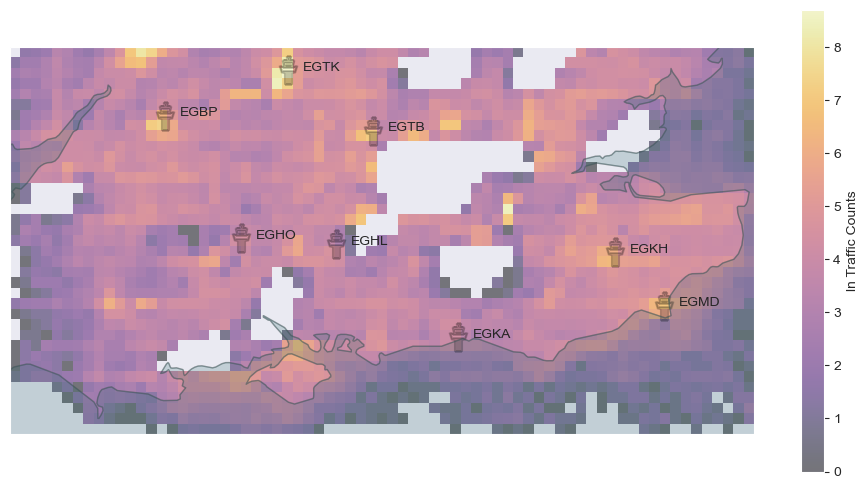

In [70]:
from cartes.crs import LambertConformal, EPSG_27700, PlateCarree, EuroPP, Mercator, Projection
from traffic.drawing import countries, lakes, ocean
bounds = (-2.9, 1.5, 50.5, 51.9)

fig, ax = plt.subplots(
    1, 1, figsize=(12,6), subplot_kw=dict(projection=Projection('epsg:3857')),
)

ax.add_feature(countries())
ax.add_feature(lakes())
ax.add_feature(ocean())
# ax.set_extent(bounds)
# ax.set_global()

xs = np.sort(tfc_magg['flight_id_nunique'].reset_index()['x'].unique().astype(int))
ys = np.sort(tfc_magg['flight_id_nunique'].reset_index()['y'].unique().astype(int))

pcm = ax.pcolormesh(xs, ys, np.log(tfc_magg['flight_id_nunique'].reset_index().pivot_table('flight_id_nunique', 'y', 'x', fill_value=np.nan))
, cmap='inferno', alpha=0.5)

airports['EGHL'].point.plot(ax, alpha=0.2)
airports['EGTK'].point.plot(ax, alpha=0.2)
airports['EGKA'].point.plot(ax, alpha=0.2)
airports['EGMD'].point.plot(ax, alpha=0.2)
airports['EGTB'].point.plot(ax, alpha=0.2)
airports['EGHO'].point.plot(ax, alpha=0.2)
airports['EGBP'].point.plot(ax, alpha=0.2)
airports['EGKH'].point.plot(ax, alpha=0.2)

cb = fig.colorbar(pcm)
cb.set_label('ln Traffic Counts')
# tfc_magg['flight_id_nunique'].to_xarray().sortby('x').plot.pcolormesh(
#     ax=ax,
#     alpha=0.4,
#     cmap="inferno",
# )
# fig.show()

Plot a correlation matrix between all variables using the Pearson Correlation Coefficient

In [ ]:
# corr = airproxes_with_tfc.corr(method='spearman')
corr = airproxes_with_tfc.apply(lambda x: pd.factorize(x)[0]).corr(method='pearson', min_periods=1)
fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(corr, square=True, cmap=sns.color_palette('icefire', as_cmap=True), annot=True, ax=ax)
plt.savefig('corr.svg')

Compute vectors for the quiver plot

In [72]:
tfc_mgdf['track_scale'] = 1 - (tfc_mgdf['track_std'] / tfc_mgdf['track_std'].max())
tfc_mgdf['track_u'] = np.cos(np.radians(tfc_mgdf['track_mean'])) * tfc_mgdf['track_scale']
tfc_mgdf['track_v'] = np.sin(np.radians(tfc_mgdf['track_mean'])) * tfc_mgdf['track_scale']
tfc_mgdf.head()

,x,y,altitude_mean,altitude_std,track_mean,track_std,groundspeed_mean,groundspeed_std,flight_id_nunique,track_scale,track_u,track_v
0,-329000.0,6566000.0,650.00,494.974747,73.00000,4.861359,131.00000,11.313708,2,0.975114,0.284726,0.932739
1,-329000.0,6573000.0,303.25,7.572838,182.62500,47.351880,33.71875,19.015898,1,0.757602,-0.756862,-0.034773
2,-329000.0,6580000.0,975.00,0.000000,60.65625,0.000000,120.00000,0.000000,1,1.000000,0.489990,0.871582
3,-329000.0,6587000.0,850.00,0.000000,16.18750,0.044194,113.00000,2.828427,1,0.999774,0.960232,0.278746
4,-329000.0,6608000.0,850.00,NaN,233.87500,NaN,113.00000,NaN,1,NaN,NaN,NaN


Plot the mean traffic flow direction for cells with sufficient samples. The scale of the vectors is inversely proportional to the standard deviation of the distribution of directions for that cell. In practice, this means the longer the arrow the more unidirectional and organised the traffic flow is.

Vector colouring is based on direction of the vector and is only to provide more visual difference.

Airprox locations are superimposed for information only.

Both a quiver and contour plot are made to based on the same data

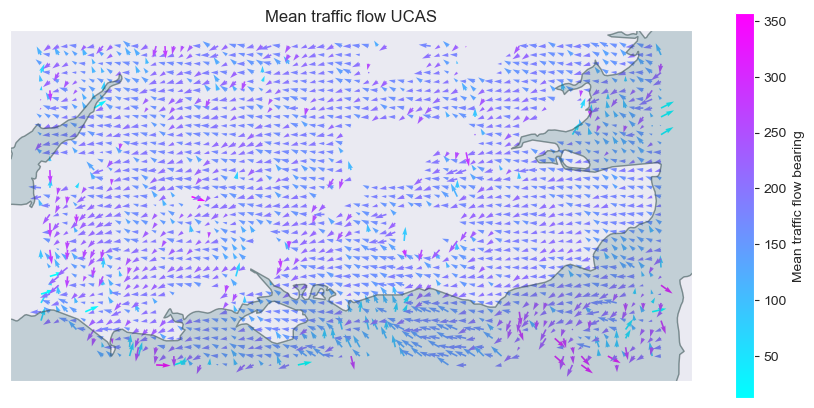

In [73]:
fig, ax = plt.subplots(
    1, 1, figsize=(11, 5), subplot_kw=dict(projection=Projection('epsg:3857')),
)

ax.add_feature(countries())
ax.add_feature(lakes())
ax.add_feature(ocean())

flow = ax.quiver(tfc_mgdf['x'],
                 tfc_mgdf['y'],
                 tfc_mgdf['track_u'],
                 tfc_mgdf['track_v'],
                 tfc_mgdf['track_mean'],
                 scale_units=None,
                 cmap='cool')

# aps = ax.scatter(airprox_gdf['x'], airprox_gdf['y'], c='r', marker='x')

ax.set_title('Mean traffic flow UCAS')
cb = fig.colorbar(flow)
cb.set_label('Mean traffic flow bearing')
# ax.legend([aps], ['Airprox'])

# airports['EGHQ'].point.plot(ax)
# airports['EGHE'].point.plot(ax)
# airports['EGHC'].point.plot(ax)

/tmp/ipykernel_17767/2645729871.py:43: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "tightlayout" which is no longer supported as of 3.3 and will become an error in 3.6
  fig.savefig(f'southeng_quiver_{floor}.png', tightlayout=True)
/tmp/ipykernel_17767/2645729871.py:43: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "tightlayout" which is no longer supported as of 3.3 and will become an error in 3.6
  fig.savefig(f'southeng_quiver_{floor}.png', tightlayout=True)
/tmp/ipykernel_17767/2645729871.py:43: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "tightlayout" which is no longer supported as of 3.3 and will become an error in 3.6
  fig.savefig(f'southeng_quiver_{floor}.png', tightlayout=True)


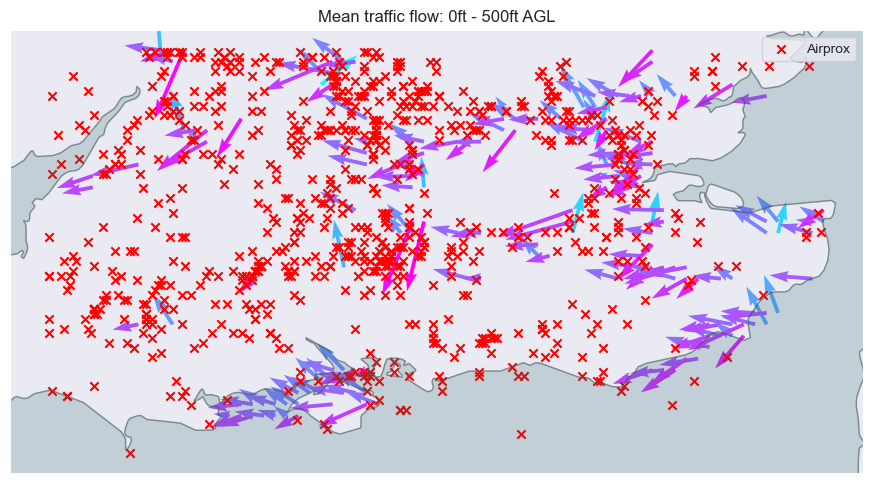

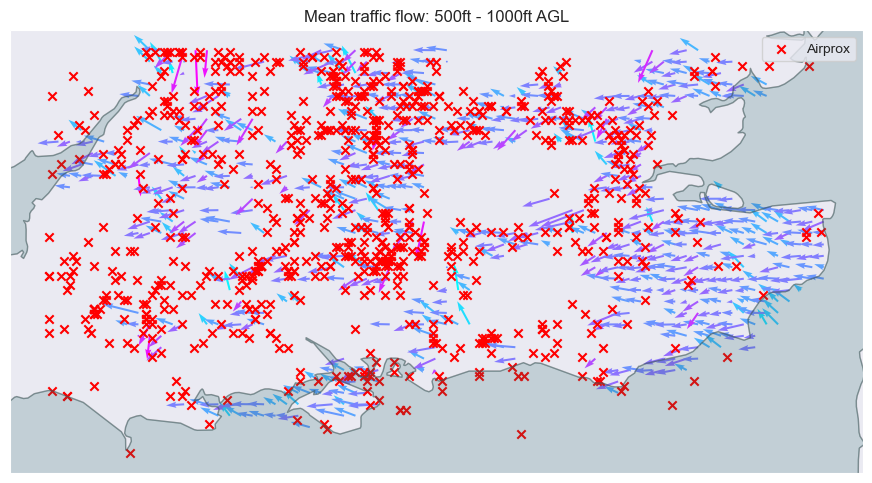

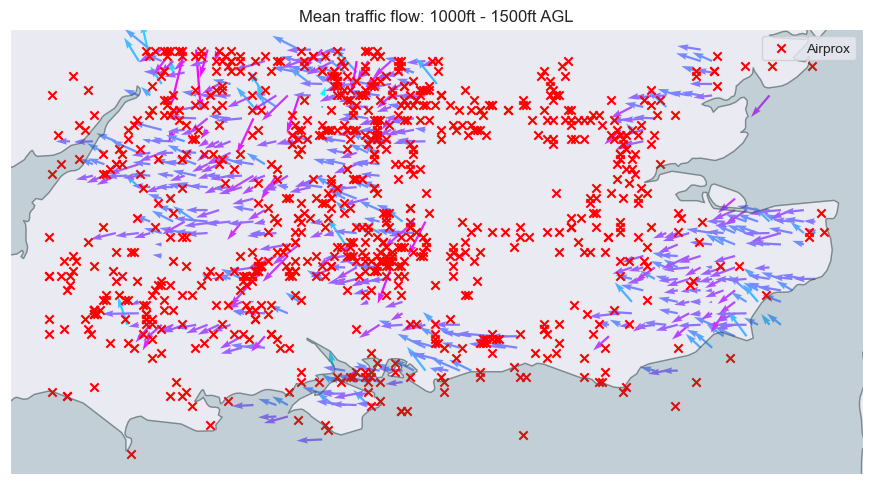

In [74]:
alt_tfc_magg = []
alt_bins = range(0,int(1500+1), 500)
for floor, ceil in zip(alt_bins, alt_bins[1:]):
    tfc_alt_gdf = tfc_unc_xy_gdf.data[(tfc_unc_xy_gdf.data['altitude'] >= floor) & (tfc_unc_xy_gdf.data['altitude'] < ceil)]
    tfc_alt_agg = tfc_alt_gdf.assign(
        x=lambda elt: (elt.x // res) * res,
        y=lambda elt: (elt.y // res) * res,
    ).groupby(["x", "y"]).agg(altitude_mean=pd.NamedAgg('altitude', np.nanmean),
                              altitude_std=pd.NamedAgg('altitude', np.std), track_mean=pd.NamedAgg('track', np.nanmean),
                              track_std=pd.NamedAgg('track', np.std),
                              groundspeed_mean=pd.NamedAgg('groundspeed', np.nanmean),
                              groundspeed_std=pd.NamedAgg('groundspeed', np.std),
                              flight_id_nunique=('flight_id', 'nunique'))
    tfc_alt_mgdf = tfc_alt_agg[tfc_alt_agg['flight_id_nunique'] > 30].reset_index()
    alt_tfc_magg.append(tfc_alt_mgdf)
    
    tfc_alt_mgdf['track_scale'] = 1 - (tfc_alt_mgdf['track_std'] / tfc_alt_mgdf['track_std'].max())
    tfc_alt_mgdf['track_u'] = np.cos(np.radians(tfc_alt_mgdf['track_mean'])) * tfc_alt_mgdf['track_scale']
    tfc_alt_mgdf['track_v'] = np.sin(np.radians(tfc_alt_mgdf['track_mean'])) * tfc_alt_mgdf['track_scale']

    fig, ax = plt.subplots(
        1, 1, figsize=(11, 11), subplot_kw=dict(projection=Projection('epsg:3857')),
    )

    ax.add_feature(countries())
    ax.add_feature(lakes())
    ax.add_feature(ocean())

    flow = ax.quiver(tfc_alt_mgdf['x'],
                     tfc_alt_mgdf['y'],
                     tfc_alt_mgdf['track_u'],
                     tfc_alt_mgdf['track_v'],
                     tfc_alt_mgdf['track_mean'],
                     scale_units=None,
                     cmap='cool')

    aps = ax.scatter(airprox_gdf['x'], airprox_gdf['y'], c='r', marker='x')

    ax.set_title(f'Mean traffic flow: {floor}ft - {ceil}ft AGL')
    # cb = fig.colorbar(flow)
    # cb.set_label('Mean traffic flow')
    ax.legend([aps], ['Airprox'])
    fig.savefig(f'southeng_quiver_{floor}.png', tightlayout=True)


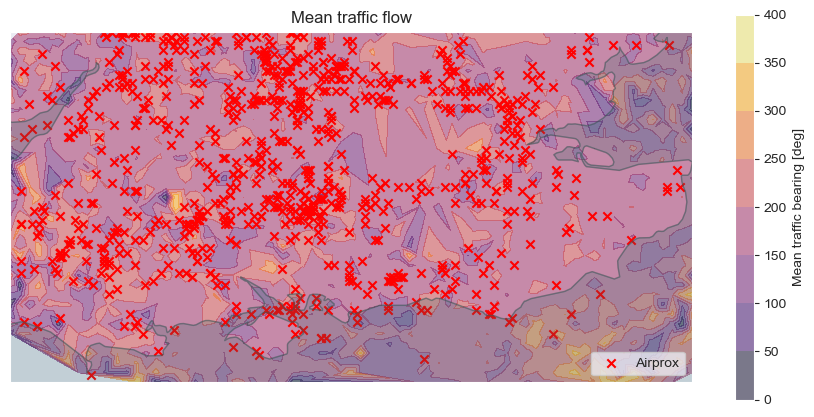

In [75]:
from cartopy.crs import Projection
from traffic.drawing import countries, lakes, ocean
from traffic.data import airports

fig, ax = plt.subplots(
    1, 1, figsize=(11, 5), subplot_kw=dict(projection=Projection('epsg:3857')),
)

ax.add_feature(countries())
ax.add_feature(lakes())
ax.add_feature(ocean())

flow = ax.tricontourf(tfc_mgdf['x'],
                      tfc_mgdf['y'],
                      # tfc_gdf['track_u'],
                      # tfc_gdf['track_v'],
                      tfc_mgdf['track_mean'],
                      alpha=0.5,
                      cmap='inferno')

aps = ax.scatter(airprox_gdf['x'], airprox_gdf['y'], c='r', marker='x')

ax.set_title('Mean traffic flow')
cb = fig.colorbar(flow)
cb.set_label('Mean traffic bearing [deg]')
ax.legend([aps], ['Airprox'])

# airports['EGHQ'].point.plot(ax)
# airports['EGHE'].point.plot(ax)
# airports['EGHC'].point.plot(ax)

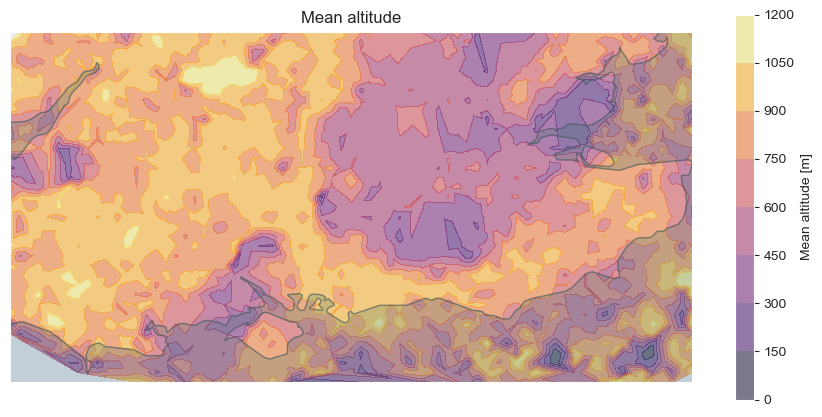

In [76]:
fig, ax = plt.subplots(
    1, 1, figsize=(11, 5), subplot_kw=dict(projection=Projection('epsg:3857')),
)

ax.add_feature(countries())
ax.add_feature(lakes())
ax.add_feature(ocean())

flow = ax.tricontourf(
    tfc_mgdf['x'],
    tfc_mgdf['y'],
    tfc_mgdf['altitude_mean'],
    alpha=0.5,
    cmap='inferno')

# aps = ax.scatter(airprox_gdf['x'], airprox_gdf['y'], c='r', marker='x')

ax.set_title('Mean altitude')
cb = fig.colorbar(flow)
cb.set_label('Mean altitude [m]')
# ax.legend([aps], ['Airprox'])

# Aggregate Stats

In [63]:
import shapely.geometry as sg

print('World space stats (uncontrolled volumes):')
ceiling_alt = 304.8 * 4
bounds = (-2.9, 50.5, 1.5, 51.9)
transformer = pyproj.Transformer.from_proj(pyproj.Proj("epsg:4326"), pyproj.Proj("epsg:3857"), always_xy=True)
trans_bounds = transformer.transform_bounds(*bounds)
bound_poly = sg.box(*trans_bounds)
total_vol = bound_poly.area * ceiling_alt
print(f"Total area: {bound_poly.area} m^2")
print(f"Total volume: {bound_poly.area * ceiling_alt} m^3")
coords = [np.array(c) for c in bound_poly.exterior.coords[:-1]]
coord_dists = np.unique(cdist(coords, coords).round(decimals=3))
coord_dists = coord_dists[coord_dists > 0]
print(f'Total x,y,z dimensions are {coord_dists[0]}m, {coord_dists[1]}m, {ceiling_alt}m with xy diagonal {coord_dists[2]}m')

World space stats (uncontrolled volumes):
Total area: 121835636925.99446 m^2
Total volume: 148542008540172.44 m^3
Total x,y,z dimensions are 248742.761m, 489805.759m, 1219.2m with xy diagonal 549347.47m


In [64]:
total_tfc = len(unc_asp_tfc_gdf.groupby('flight_id').groups)
print(f'Total Traffic Density in uncontrolled airspace over year: {total_tfc/total_vol/8766} aircraft/m^3/hr')

Total Traffic Density in uncontrolled airspace over year: 3.396155928616543e-14 aircraft/m^3/hr


If we discard cells without any traffic recorded for the year, we can get the traffic density for all the areas aircraft actually fly

In [65]:
cell_vol = res * res * ceiling_alt
data_vol = len(tfc_magg['flight_id_nunique']) * cell_vol
print(f'Data Volume: {data_vol}')
print(f'Mean Traffic Density in uncontrolled airspace over year for data area: {total_tfc/data_vol/8766} aircraft/m^3/hour')
# print(f'Equivalent to an aircraft per {np.sqrt((1/cell_traffic_densities.mean())/152.4)}m x 500ft cuboid per hour')

Data Volume: 137941507200000.0
Mean Traffic Density in uncontrolled airspace over year for data area: 3.65714303977328e-14 aircraft/m^3/hour


## Testing hypotheses
All tests are done to 5% significance unless otherwise specified.

In [47]:
from scipy import stats as ss

sig_lvl = 0.05

### Track correlation
First, the correlation of direction variance with airprox location is tested. The mean standard deviation for directions in the entire area is found and compared to that of just where airproxes occurred:

In [48]:
print('Overall mean of stddev: ', non_airprox_tfc['track_std'].mean(), ' for ', len(non_airprox_tfc['track_std']),
      ' samples')
print('Airprox location mean of stddev: ', airproxes_with_tfc['track_std'].mean(), 'for ',
      len(airproxes_with_tfc['track_std']), ' samples')

Overall mean of stddev:  88.7358743993741  for  1760  samples
Airprox location mean of stddev:  93.7216843136308 for  834  samples


In [49]:
F, p = ss.bartlett(non_airprox_tfc['track_std'], airproxes_with_tfc['track_std'])
print(f'Bartlett equal variance test gives score of {F} at a p-significance of {p}')
if p <= sig_lvl:
    print(f'The hypothesis is accepted (F={F}, p={p})')
else:
    print('Null hypothesis is accepted.')

Bartlett equal variance test gives score of 198.38322127541275 at a p-significance of 4.706046318187898e-45
The hypothesis is accepted (F=198.38322127541275, p=4.706046318187898e-45)


### Density Correlation

The count of unique flights within a cell is used as a measure of traffic density.

Otherwise the same procedure as above

In [50]:
print('Overall mean: ', non_airprox_tfc['flight_id_nunique'].mean(), ' for ', len(non_airprox_tfc['flight_id_nunique']),
      ' samples')
print('Airprox location mean: ', airproxes_with_tfc['flight_id_nunique'].mean(), 'for ',
      len(airproxes_with_tfc['flight_id_nunique']), ' samples')

Overall mean:  55.19715909090909  for  1760  samples
Airprox location mean:  169.757793764988 for  834  samples


In [51]:
F, p = ss.f_oneway(non_airprox_tfc['flight_id_nunique'], airproxes_with_tfc['flight_id_nunique'])
print(f'One-Way ANOVA test gives F-score of {F} at a p-significance of {p}')
if p <= sig_lvl:
    print(f'The hypothesis is accepted (F={F}, p={p})')
else:
    print('Null hypothesis is accepted.')

One-Way ANOVA test gives F-score of 52.730759201850844 at a p-significance of 5.034346879381711e-13
The hypothesis is accepted (F=52.730759201850844, p=5.034346879381711e-13)


### Speed correlation

First the difference in the overall traffic flow speed is compared between airprox and non-airprox traffic

In [52]:
print('Overall mean: ', np.array(non_airprox_tfc['groundspeed_mean']).mean(), ' for ',
      len(non_airprox_tfc['groundspeed_mean']),
      ' samples')
print('Airprox location mean: ', np.array(airproxes_with_tfc['groundspeed_mean']).mean(), 'for ',
      len(airproxes_with_tfc['groundspeed_mean']), ' samples')

Overall mean:  114.7  for  1760  samples
Airprox location mean:  102.3 for  834  samples


In [53]:
F, p = ss.f_oneway(non_airprox_tfc['groundspeed_mean'], airproxes_with_tfc['groundspeed_mean'])
print(f'One-Way ANOVA test gives F-score of {F} at a p-significance of {p}')
if p <= sig_lvl:
    print(f'The hypothesis is accepted (F={F}, p={p})')
else:
    print('Null hypothesis is accepted.')

One-Way ANOVA test gives F-score of 44.588175590350694 at a p-significance of 2.9640636552549365e-11
The hypothesis is accepted (F=44.588175590350694, p=2.9640636552549365e-11)


Now the difference in *spread* of traffic flow speeds is compared between airprox and non-airprox traffic

In [54]:
print('Overall mean of stddev: ', np.nanmean(np.array(non_airprox_tfc['groundspeed_std'])), ' for ',
      len(non_airprox_tfc['groundspeed_std']),
      ' samples')
print('Airprox location mean of stddev: ', np.nanmean(np.array(airproxes_with_tfc['groundspeed_std'])), 'for ',
      len(airproxes_with_tfc['groundspeed_std']), ' samples')

Overall mean of stddev:  50.7338088164785  for  1760  samples
Airprox location mean of stddev:  43.496145286505076 for  834  samples


In [55]:
F, p = ss.bartlett(non_airprox_tfc['groundspeed_std'], airproxes_with_tfc['groundspeed_std'])
print(f'Bartlett equal variance test gives score of {F} at a p-significance of {p}')
if p <= sig_lvl:
    print(f'The hypothesis is accepted (F={F}, p={p})')
else:
    print('Null hypothesis is accepted.')

Bartlett equal variance test gives score of 49.096784137994625 at a p-significance of 2.436393225943606e-12
The hypothesis is accepted (F=49.096784137994625, p=2.436393225943606e-12)
